In [1]:
from __future__ import division, print_function

In [12]:
deltasvm_pos_file = "deltasvm_out/positives_gkmsvm_t3_l10_k6_d3_c10_g2_t16_negset5.txt"
deltasvm_neg_file = "deltasvm_out/negatives_gkmsvm_t3_l10_k6_d3_c10_g2_t16_negset5.txt"

In [81]:
ism_pos_file = "ism_out/ism_diff_pos_51_gkmsvm_t3_l10_k6_d3_c10_g2_t16_negset5.txt"
ism_neg_file = "ism_out/ism_diff_neg_51_gkmsvm_t3_l10_k6_d3_c10_g2_t16_negset5.txt"

In [13]:
gkmexplain_pos_file = "gkmexplain_out/positives_51_gkmsvm_t3_l10_k6_d3_c10_g2_t16_negset5.txt"
gkmexplain_neg_file = "gkmexplain_out/negatives_51_gkmsvm_t3_l10_k6_d3_c10_g2_t16_negset5.txt"

In [14]:
!head $deltasvm_pos_file

chr1:846437-846455	0.871927
chr1:901449-901467	1.738138
chr1:1176356-1176374	-4.266131
chr1:1217266-1217284	-3.287120
chr1:1580429-1580447	-2.686060
chr1:3359698-3359716	-2.476525
chr1:11731980-11731998	-0.665871
chr1:11964839-11964857	1.969763
chr1:15583631-15583649	-1.424230
chr1:18774835-18774853	2.610272


In [16]:
!head $gkmexplain_pos_file

chr1:846420-846471	0.138453	0	A
chr1:901432-901483	0.253432	2	G
chr1:1176339-1176390	-0.650924	3	T
chr1:1217249-1217300	-0.499652	0	A
chr1:1580412-1580463	-0.421219	0	A
chr1:3359681-3359732	-0.383906	2	G
chr1:11731963-11732014	-0.103051	2	G
chr1:11964822-11964873	0.300329	0	A
chr1:15583614-15583665	-0.222279	0	A
chr1:18774818-18774869	0.414896	1	C


In [82]:
import numpy as np

def read_scores(file_name):
    return np.array([float(x.rstrip().split("\t")[1]) for x in open(file_name)])

deltasvm_scores_pos = read_scores(deltasvm_pos_file)
deltasvm_scores_neg = read_scores(deltasvm_neg_file)
ism_scores_pos = read_scores(ism_pos_file)
ism_scores_neg = read_scores(ism_neg_file)
gkmexplain_scores_pos = read_scores(gkmexplain_pos_file)
gkmexplain_scores_neg = read_scores(gkmexplain_neg_file)

In [83]:
%matplotlib inline
from matplotlib import pyplot as plt

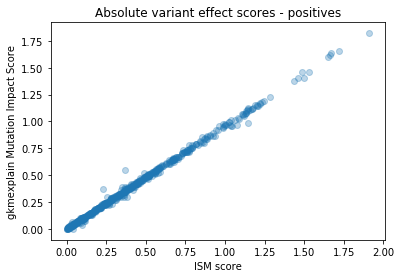

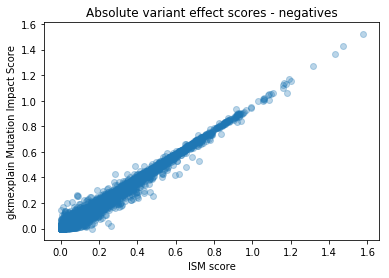

In [84]:
plt.scatter(np.abs(ism_scores_pos), np.abs(gkmexplain_scores_pos), alpha=0.3)
plt.title("Absolute variant effect scores - positives")
plt.xlabel("ISM score")
plt.ylabel("gkmexplain Mutation Impact Score")
plt.show()

plt.scatter(np.abs(ism_scores_neg), np.abs(gkmexplain_scores_neg), alpha=0.3)
plt.title("Absolute variant effect scores - negatives")
plt.xlabel("ISM score")
plt.ylabel("gkmexplain Mutation Impact Score")
plt.show()

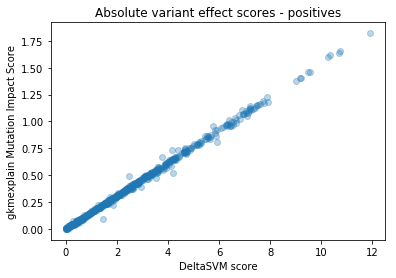

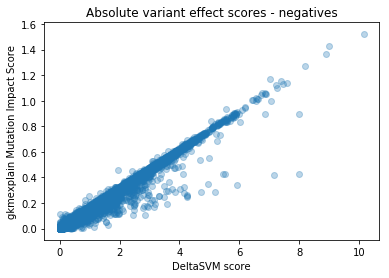

In [85]:
plt.scatter(np.abs(deltasvm_scores_pos), np.abs(gkmexplain_scores_pos), alpha=0.3)
plt.title("Absolute variant effect scores - positives")
plt.xlabel("DeltaSVM score")
plt.ylabel("gkmexplain Mutation Impact Score")
plt.show()

plt.scatter(np.abs(deltasvm_scores_neg), np.abs(gkmexplain_scores_neg), alpha=0.3)
plt.title("Absolute variant effect scores - negatives")
plt.xlabel("DeltaSVM score")
plt.ylabel("gkmexplain Mutation Impact Score")
plt.show()

In [86]:
#for each positive, compute the precision
def compute_precision_of_positives(positives_scores, negatives_scores):
    combined_index_n_score_n_label = (list(enumerate((x,1) for x in positives_scores))+
                                          list(enumerate((x,0) for x in negatives_scores)))
    sorted_index_n_score_n_label = sorted(combined_index_n_score_n_label,
                                          key=lambda x: -x[1][0])
    labels_so_far = np.array([x[1][1] for x in sorted_index_n_score_n_label])
    precision_so_far = np.cumsum(labels_so_far)/(np.arange(len(labels_so_far))+1)
    positives_precisions = np.zeros(len(positives_scores))
    for ((index,(score,label)),precision) in zip(sorted_index_n_score_n_label,precision_so_far):
        if (label==1):
            positives_precisions[index] = precision
    return positives_precisions

gkmexplain_precisions = compute_precision_of_positives(np.abs(gkmexplain_scores_pos),
                                                       np.abs(gkmexplain_scores_neg))
deltasvm_precisions = compute_precision_of_positives(np.abs(deltasvm_scores_pos),
                                                     np.abs(deltasvm_scores_neg))
ism_precisions = compute_precision_of_positives(np.abs(ism_scores_pos),
                                                     np.abs(ism_scores_neg))
    

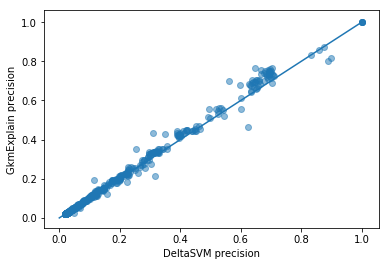

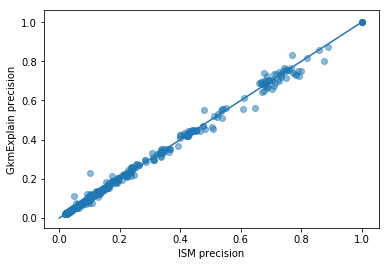

In [87]:
plt.scatter(deltasvm_precisions,gkmexplain_precisions, alpha=0.5)
plt.plot([0,1],[0,1])
plt.xlabel("DeltaSVM precision")
plt.ylabel("GkmExplain precision")
plt.show()

plt.scatter(ism_precisions,gkmexplain_precisions, alpha=0.5)
plt.plot([0,1],[0,1])
plt.xlabel("ISM precision")
plt.ylabel("GkmExplain precision")
plt.show()

In [98]:
indices_of_interest = np.nonzero(
    (gkmexplain_precisions > 0.6)*
    (gkmexplain_precisions-deltasvm_precisions > 0.05)
    #*(gkmexplain_precisions-ism_precisions > 0.0)
)[0]
print(len(indices_of_interest))

20


In [99]:
#read in the file of positives with a 51bp flank
positives_seqs = [x.rstrip() for (i,x) in enumerate(open("posmajor_51flank_coords.fa"))
                  if i%2==1]
alt_alleles = [x.rstrip().split("\t")[3] for x in open(gkmexplain_pos_file)]
positives_ids  = [x.rstrip() for (i,x) in enumerate(open("posmajor_51flank_coords.fa"))
                  if i%2==0]

In [100]:
#score regions of interest with gkmexplain, plot the scores
tempfile = open("tempfile.fa",'w')
for idx_of_interest in indices_of_interest:
    tempfile.write(positives_ids[idx_of_interest]+"\n")
    tempfile.write(positives_seqs[idx_of_interest]+"\n")
tempfile.close()

In [101]:
!~/lsgkm/bin/gkmexplain tempfile.fa ../gkmsvm_t3_l10_k6_d3_c10_g2_t16_negset5.model.txt tempexplainations.txt

INFO 2019-01-28 19:53:50: Number of threads is set to 1
INFO 2019-01-28 19:53:50: load model ../gkmsvm_t3_l10_k6_d3_c10_g2_t16_negset5.model.txt
INFO 2019-01-28 19:53:50: reading... 1000/32712
INFO 2019-01-28 19:53:51: reading... 2000/32712
INFO 2019-01-28 19:53:51: reading... 3000/32712
INFO 2019-01-28 19:53:51: reading... 4000/32712
INFO 2019-01-28 19:53:52: reading... 5000/32712
INFO 2019-01-28 19:53:52: reading... 6000/32712
INFO 2019-01-28 19:53:53: reading... 7000/32712
INFO 2019-01-28 19:53:53: reading... 8000/32712
INFO 2019-01-28 19:53:53: reading... 9000/32712
INFO 2019-01-28 19:53:54: reading... 10000/32712
INFO 2019-01-28 19:53:54: reading... 11000/32712
INFO 2019-01-28 19:53:54: reading... 12000/32712
INFO 2019-01-28 19:53:55: reading... 13000/32712
INFO 2019-01-28 19:53:55: reading... 14000/32712
INFO 2019-01-28 19:53:56: reading... 15000/32712
INFO 2019-01-28 19:53:56: reading... 16000/32712
INFO 2019-01-28 19:53:57: reading... 17000/32712
INFO 2019-01-28 19:53:57: readi

In [102]:
altallelestempfile = open("altallelstempfile.fa",'w')
for idx_of_interest in indices_of_interest:
    altallelestempfile.write(positives_ids[idx_of_interest]+"-alt\n")
    if (alt_alleles[idx_of_interest]==positives_seqs[idx_of_interest][25]):
        print("why",alt_alleles[idx_of_interest],idx_of_interest,positives_ids[idx_of_interest])
    altallelestempfile.write(positives_seqs[idx_of_interest][:25]
                   +alt_alleles[idx_of_interest]+positives_seqs[idx_of_interest][26:]+"\n")
altallelestempfile.close()

!~/lsgkm/bin/gkmexplain altallelstempfile.fa ../gkmsvm_t3_l10_k6_d3_c10_g2_t16_negset5.model.txt altallelestempexplanations.txt

INFO 2019-01-28 19:54:08: Number of threads is set to 1
INFO 2019-01-28 19:54:08: load model ../gkmsvm_t3_l10_k6_d3_c10_g2_t16_negset5.model.txt
INFO 2019-01-28 19:54:09: reading... 1000/32712
INFO 2019-01-28 19:54:09: reading... 2000/32712
INFO 2019-01-28 19:54:10: reading... 3000/32712
INFO 2019-01-28 19:54:10: reading... 4000/32712
INFO 2019-01-28 19:54:10: reading... 5000/32712
INFO 2019-01-28 19:54:11: reading... 6000/32712
INFO 2019-01-28 19:54:11: reading... 7000/32712
INFO 2019-01-28 19:54:12: reading... 8000/32712
INFO 2019-01-28 19:54:12: reading... 9000/32712
INFO 2019-01-28 19:54:12: reading... 10000/32712
INFO 2019-01-28 19:54:13: reading... 11000/32712
INFO 2019-01-28 19:54:13: reading... 12000/32712
INFO 2019-01-28 19:54:13: reading... 13000/32712
INFO 2019-01-28 19:54:14: reading... 14000/32712
INFO 2019-01-28 19:54:14: reading... 15000/32712
INFO 2019-01-28 19:54:15: reading... 16000/32712
INFO 2019-01-28 19:54:15: reading... 17000/32712
INFO 2019-01-28 19:54:16: readi

In [103]:
#read in the explanations
impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("tempexplainations.txt")
]
#read in the explanations on the mutated sequence
altimpscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("altallelestempexplanations.txt")
]

idx 58
gkmexplain score -0.915937
gkmexplain precision 0.6829268292682927
ism precision 0.6666666666666666
deltasvm precision 0.627906976744186
GkmExplain Importance on original seq:


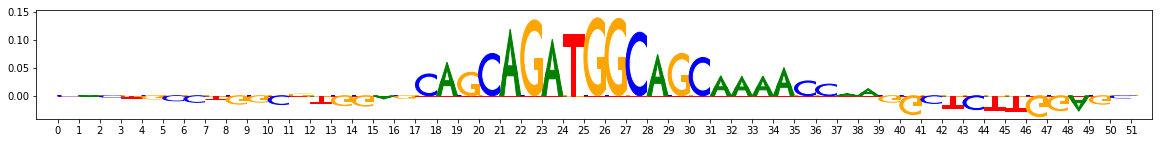

GkmExplain Importance on mutated seq:


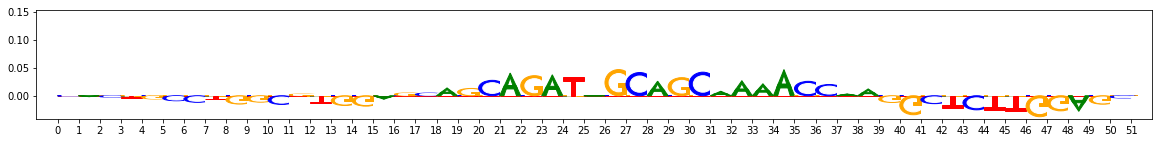

Delta


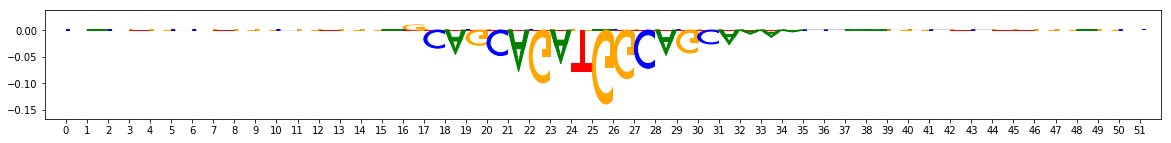

idx 65
gkmexplain score 1.07897
gkmexplain precision 0.75
ism precision 0.7380952380952381
deltasvm precision 0.6923076923076923
GkmExplain Importance on original seq:


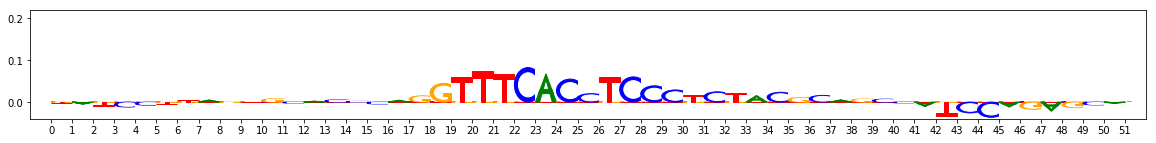

GkmExplain Importance on mutated seq:


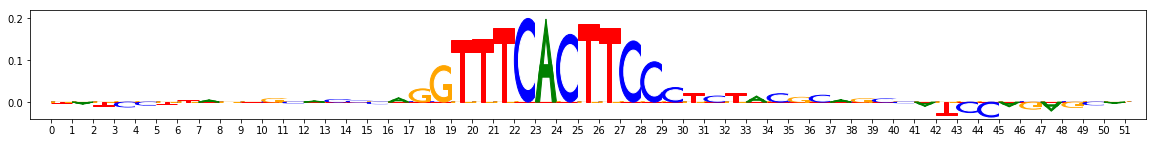

Delta


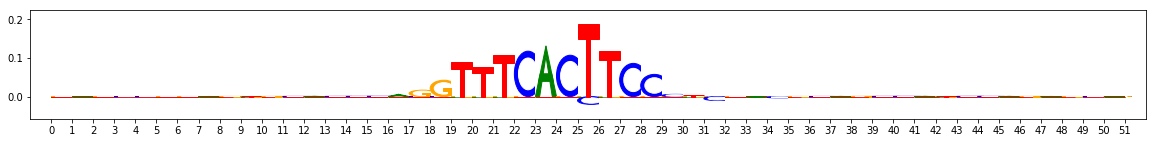

idx 68
gkmexplain score -1.16949
gkmexplain precision 0.7368421052631579
ism precision 0.7777777777777778
deltasvm precision 0.6842105263157895
GkmExplain Importance on original seq:


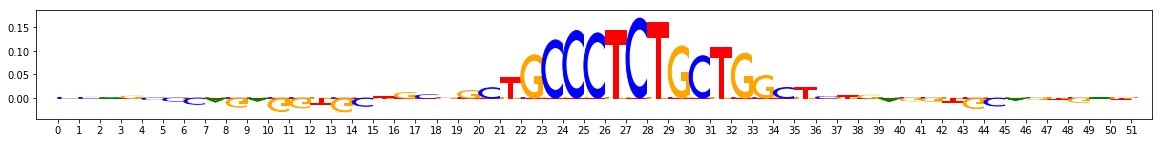

GkmExplain Importance on mutated seq:


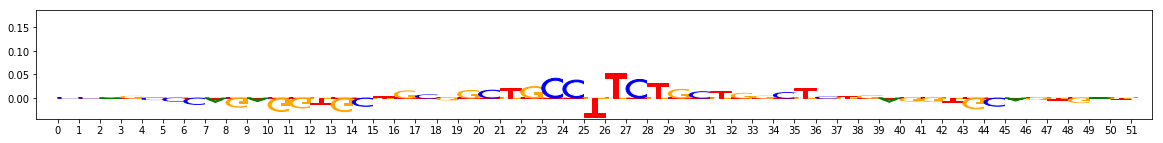

Delta


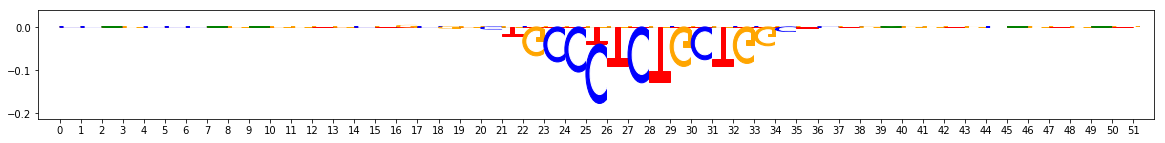

idx 70
gkmexplain score 1.18778
gkmexplain precision 0.75
ism precision 0.75
deltasvm precision 0.7
GkmExplain Importance on original seq:


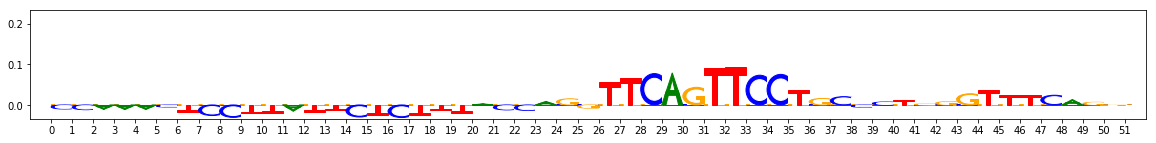

GkmExplain Importance on mutated seq:


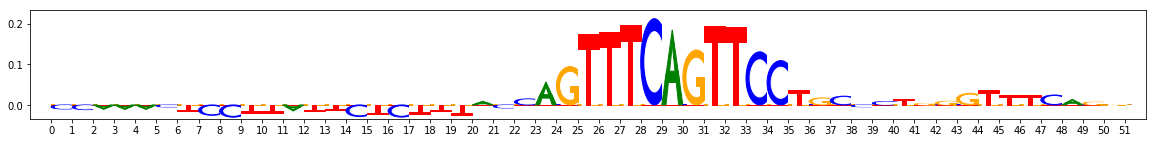

Delta


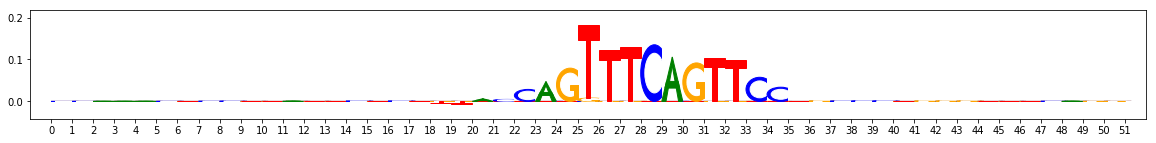

idx 147
gkmexplain score 1.10623
gkmexplain precision 0.7428571428571429
ism precision 0.6764705882352942
deltasvm precision 0.6774193548387096
GkmExplain Importance on original seq:


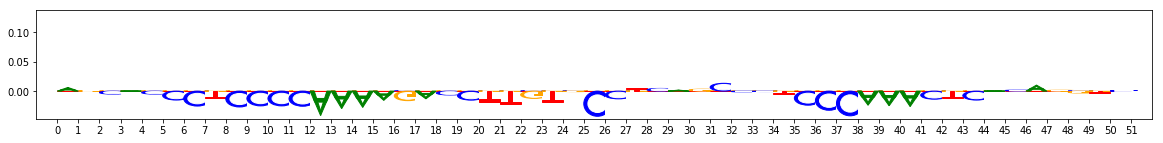

GkmExplain Importance on mutated seq:


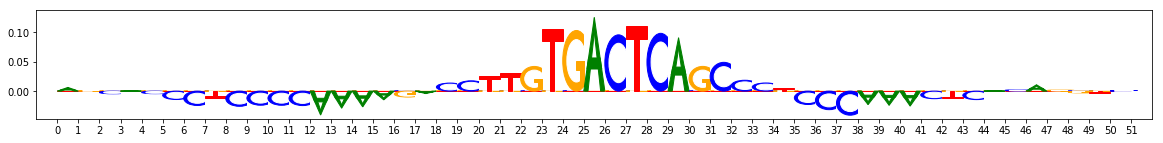

Delta


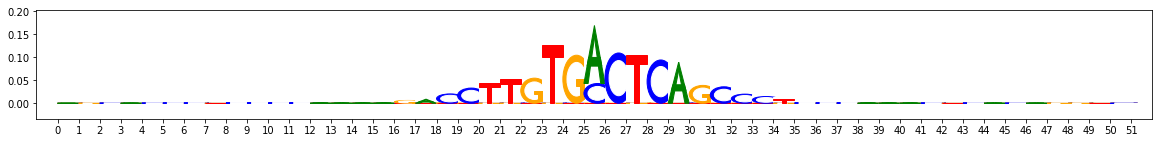

idx 173
gkmexplain score 0.968712
gkmexplain precision 0.6811594202898551
ism precision 0.676923076923077
deltasvm precision 0.6307692307692307
GkmExplain Importance on original seq:


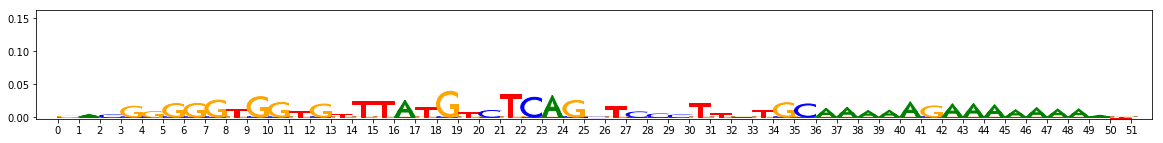

GkmExplain Importance on mutated seq:


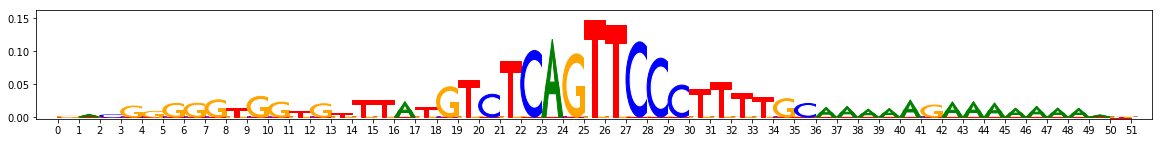

Delta


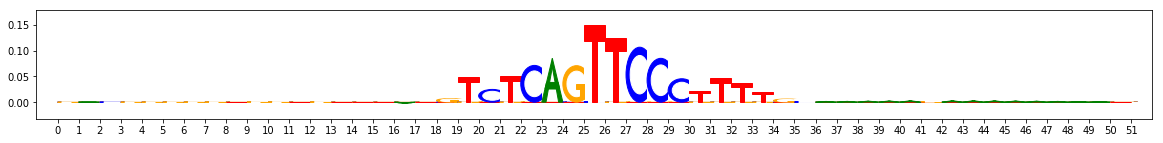

idx 191
gkmexplain score -1.18204
gkmexplain precision 0.7647058823529411
ism precision 0.7647058823529411
deltasvm precision 0.6470588235294118
GkmExplain Importance on original seq:


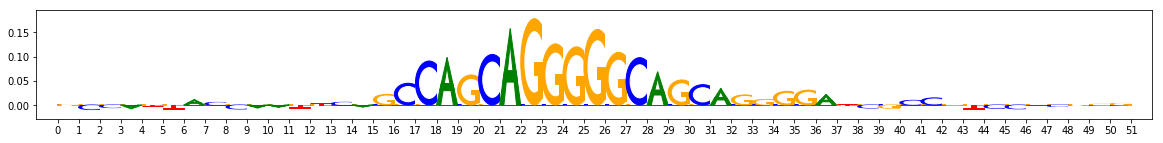

GkmExplain Importance on mutated seq:


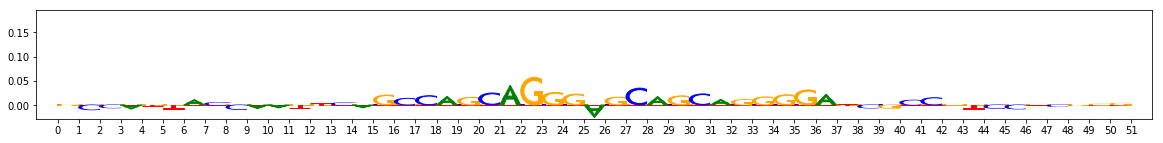

Delta


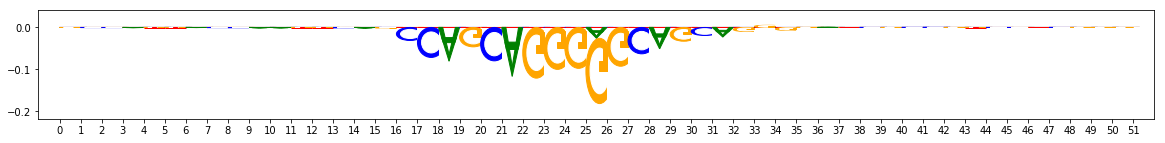

idx 194
gkmexplain score -1.16388
gkmexplain precision 0.75
ism precision 0.7894736842105263
deltasvm precision 0.6818181818181818
GkmExplain Importance on original seq:


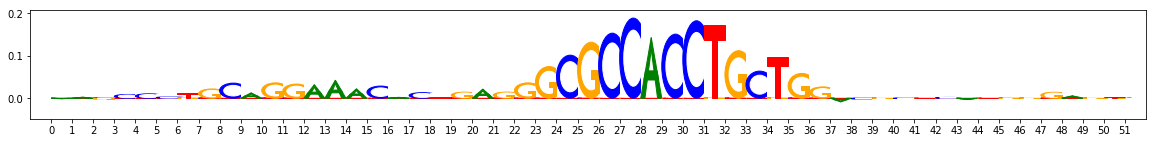

GkmExplain Importance on mutated seq:


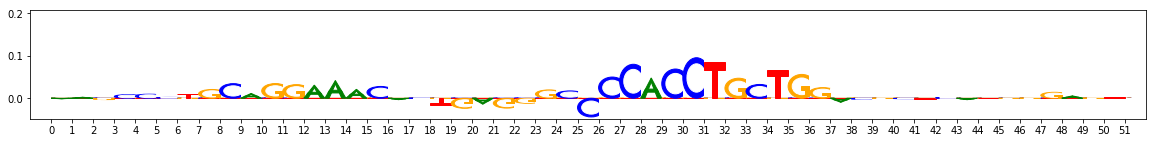

Delta


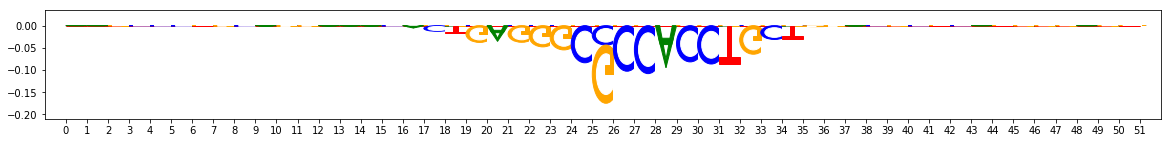

idx 263
gkmexplain score -0.923654
gkmexplain precision 0.6790123456790124
ism precision 0.6790123456790124
deltasvm precision 0.5979381443298969
GkmExplain Importance on original seq:


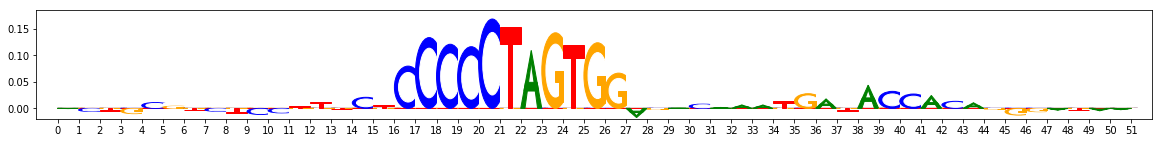

GkmExplain Importance on mutated seq:


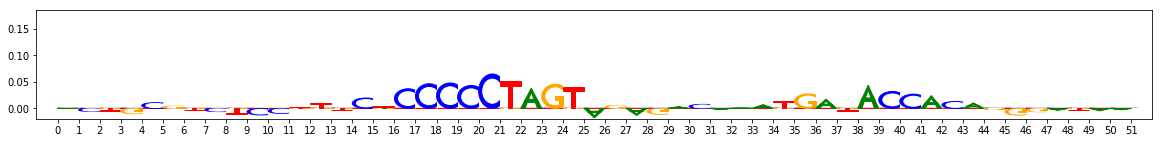

Delta


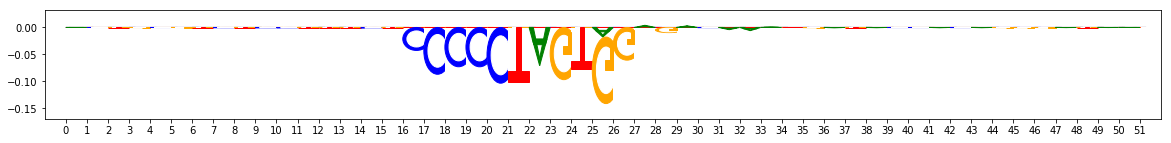

idx 309
gkmexplain score -1.05962
gkmexplain precision 0.7555555555555555
ism precision 0.7608695652173914
deltasvm precision 0.6666666666666666
GkmExplain Importance on original seq:


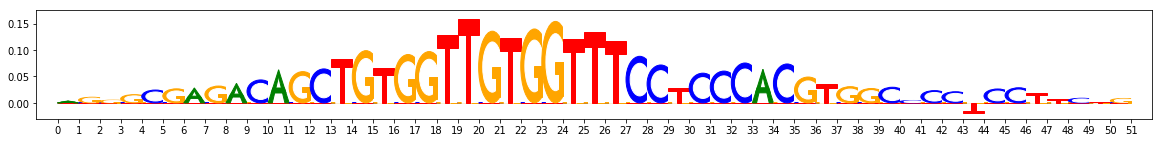

GkmExplain Importance on mutated seq:


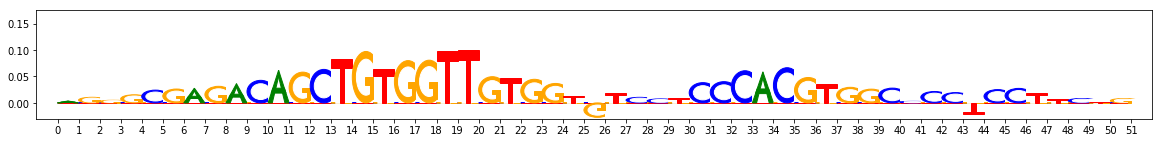

Delta


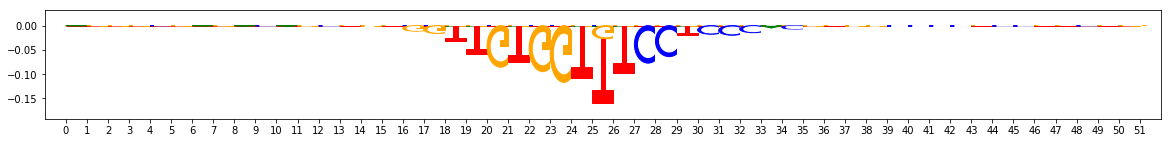

idx 314
gkmexplain score -1.0735
gkmexplain precision 0.7560975609756098
ism precision 0.7555555555555555
deltasvm precision 0.6888888888888889
GkmExplain Importance on original seq:


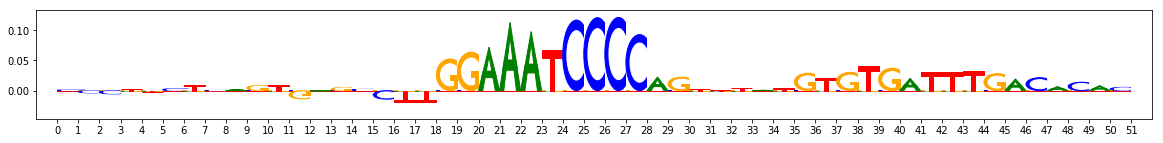

GkmExplain Importance on mutated seq:


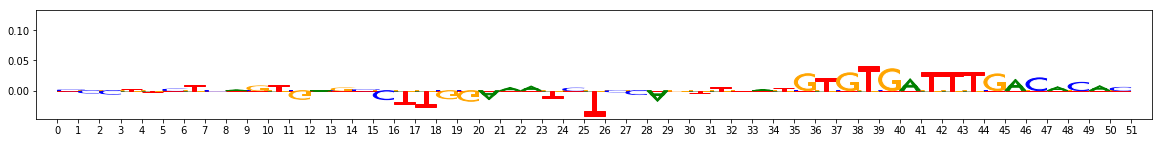

Delta


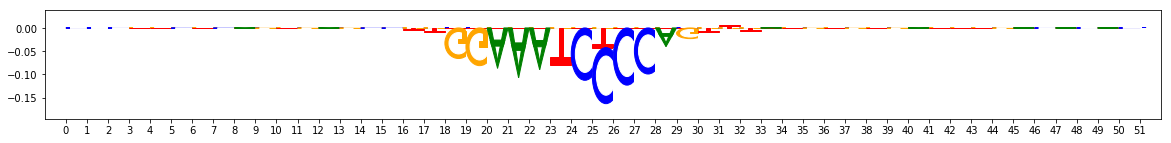

idx 330
gkmexplain score 1.07033
gkmexplain precision 0.7674418604651163
ism precision 0.7441860465116279
deltasvm precision 0.7021276595744681
GkmExplain Importance on original seq:


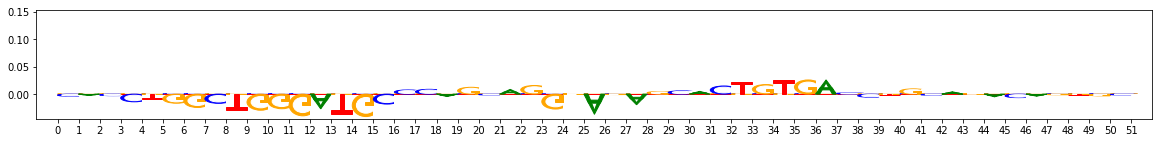

GkmExplain Importance on mutated seq:


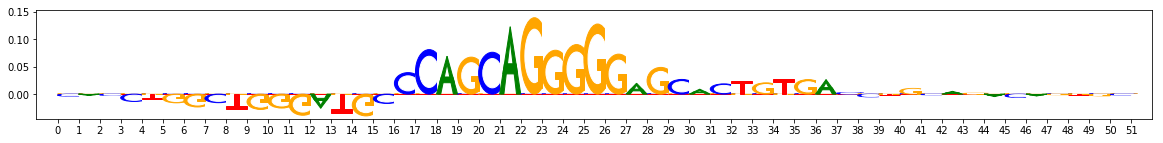

Delta


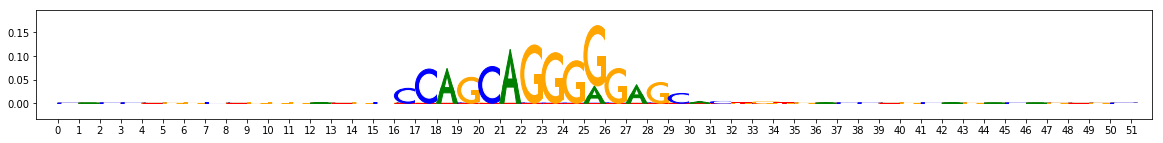

idx 367
gkmexplain score 1.14445
gkmexplain precision 0.75
ism precision 0.8
deltasvm precision 0.6923076923076923
GkmExplain Importance on original seq:


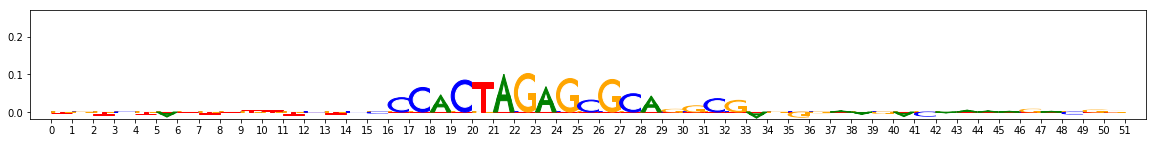

GkmExplain Importance on mutated seq:


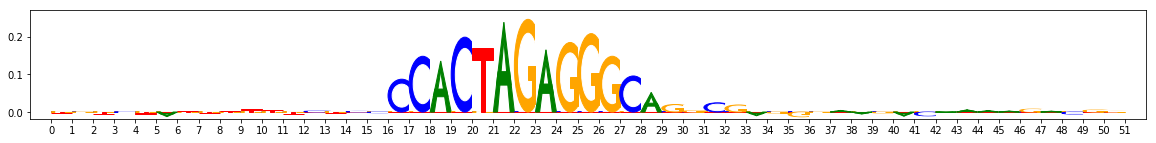

Delta


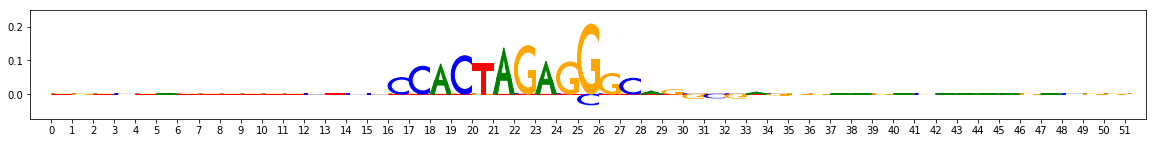

idx 388
gkmexplain score -1.07225
gkmexplain precision 0.7619047619047619
ism precision 0.75
deltasvm precision 0.6956521739130435
GkmExplain Importance on original seq:


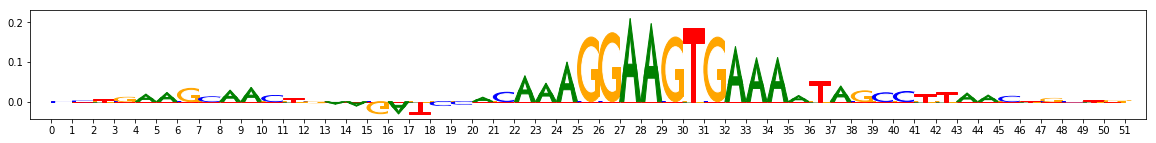

GkmExplain Importance on mutated seq:


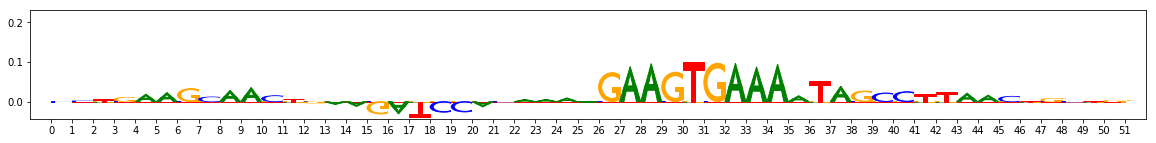

Delta


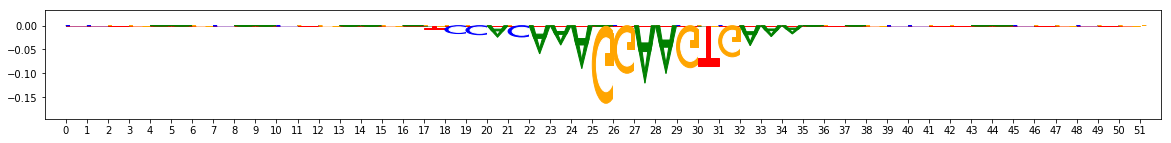

idx 410
gkmexplain score 0.961713
gkmexplain precision 0.6901408450704225
ism precision 0.6612903225806451
deltasvm precision 0.6363636363636364
GkmExplain Importance on original seq:


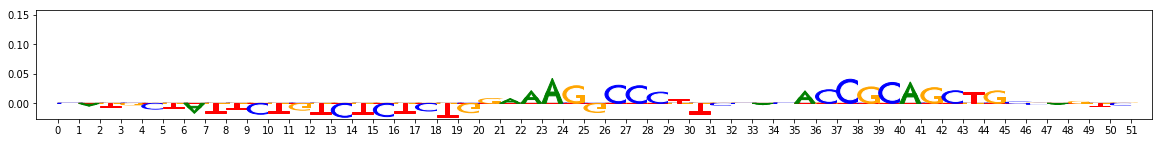

GkmExplain Importance on mutated seq:


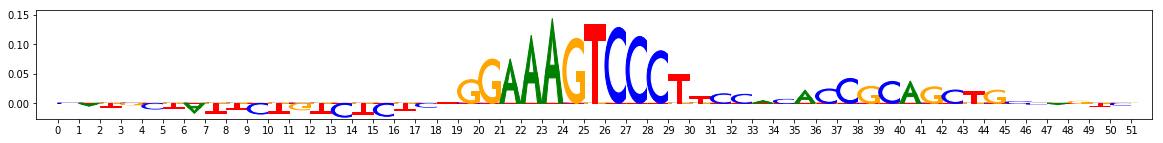

Delta


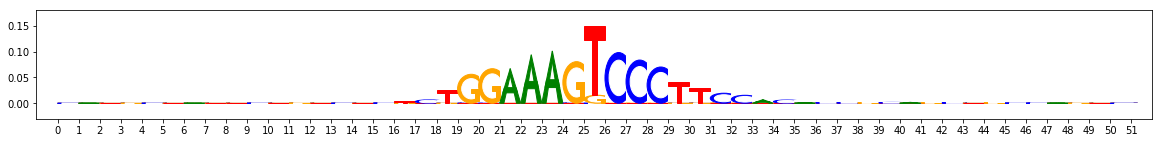

idx 449
gkmexplain score 0.955131
gkmexplain precision 0.7027027027027027
ism precision 0.6944444444444444
deltasvm precision 0.6376811594202898
GkmExplain Importance on original seq:


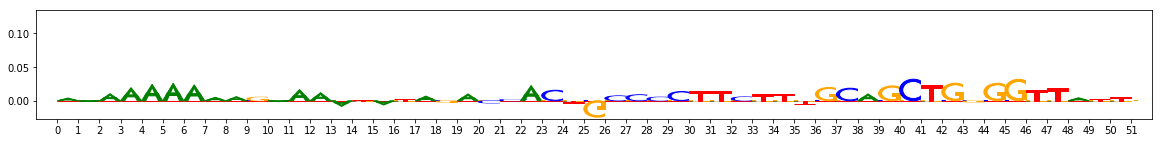

GkmExplain Importance on mutated seq:


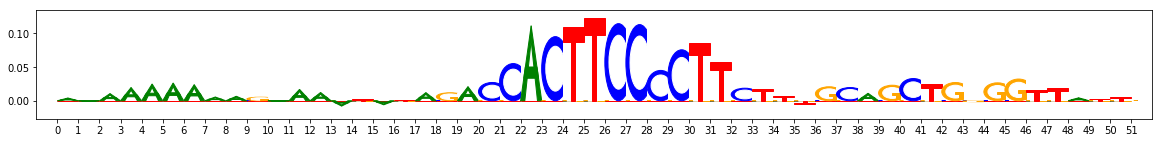

Delta


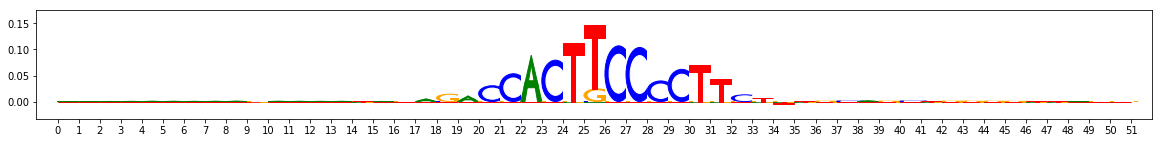

idx 489
gkmexplain score -0.950546
gkmexplain precision 0.7066666666666667
ism precision 0.68
deltasvm precision 0.65
GkmExplain Importance on original seq:


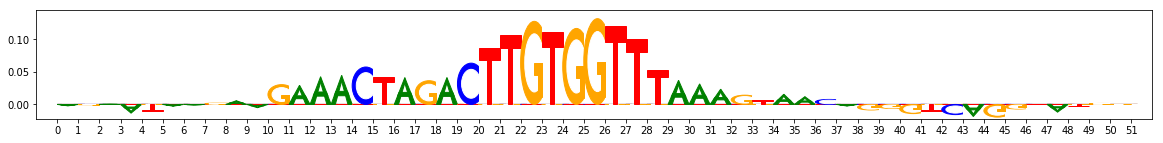

GkmExplain Importance on mutated seq:


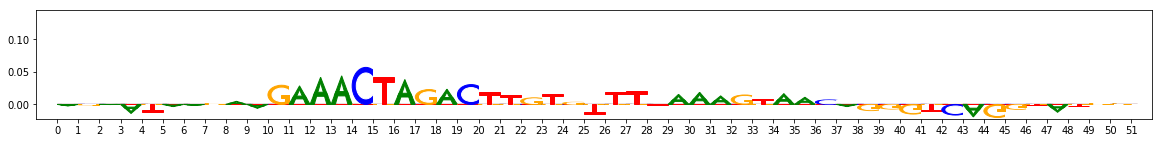

Delta


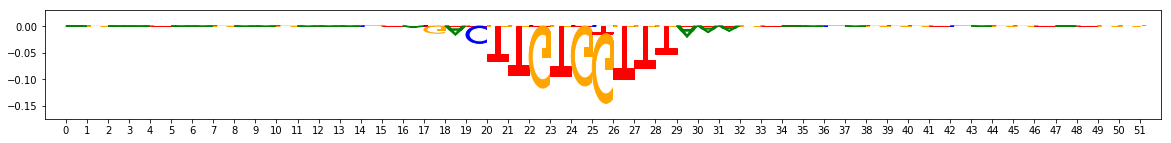

idx 495
gkmexplain score -0.958586
gkmexplain precision 0.6986301369863014
ism precision 0.6835443037974683
deltasvm precision 0.5619047619047619
GkmExplain Importance on original seq:


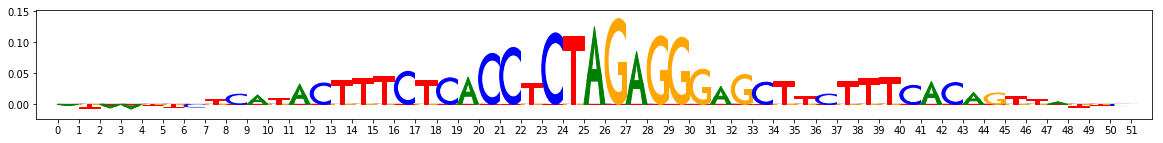

GkmExplain Importance on mutated seq:


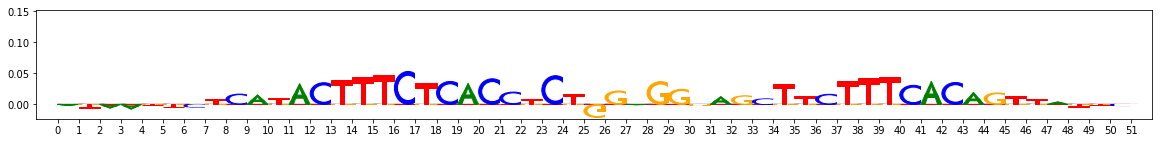

Delta


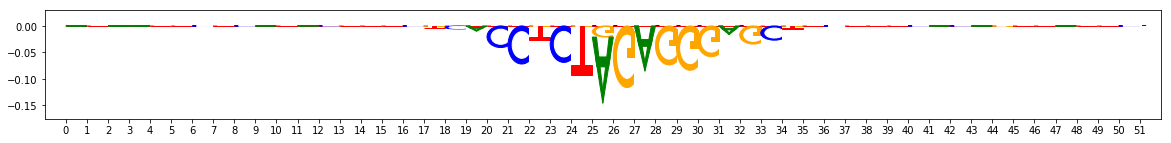

idx 498
gkmexplain score -1.2301
gkmexplain precision 0.7333333333333333
ism precision 0.7333333333333333
deltasvm precision 0.6666666666666666
GkmExplain Importance on original seq:


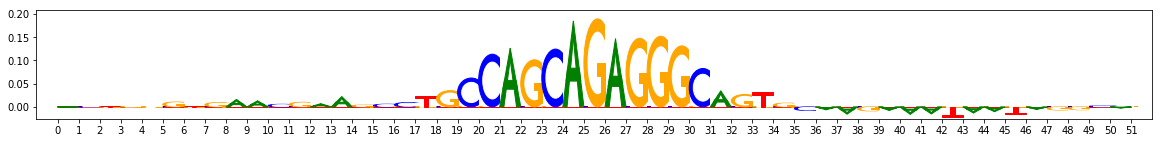

GkmExplain Importance on mutated seq:


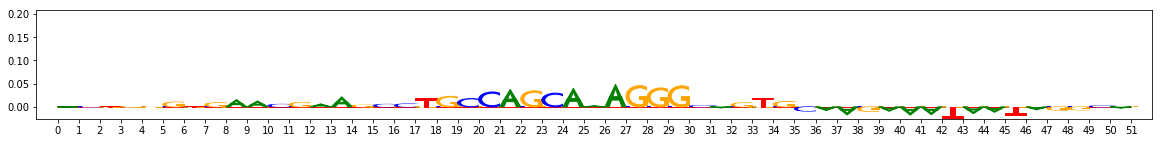

Delta


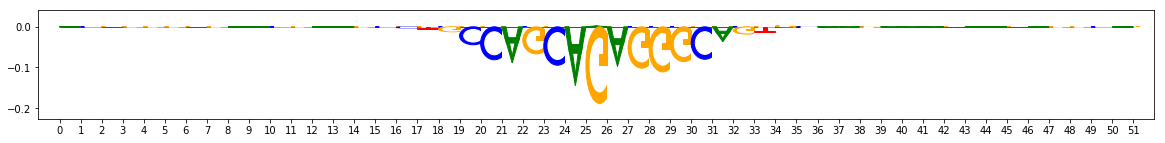

idx 527
gkmexplain score 1.01314
gkmexplain precision 0.6964285714285714
ism precision 0.6666666666666666
deltasvm precision 0.6388888888888888
GkmExplain Importance on original seq:


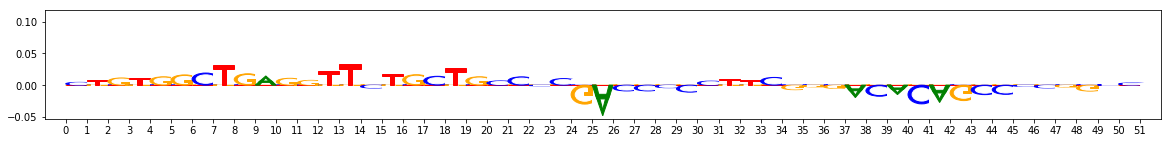

GkmExplain Importance on mutated seq:


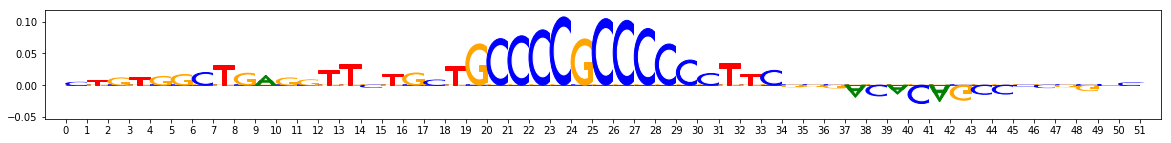

Delta


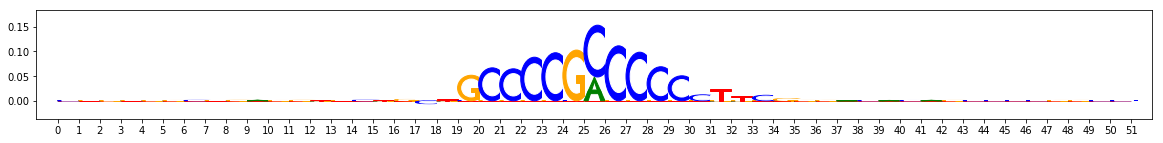

In [114]:
from vizsequence import viz_sequence
from matplotlib import pyplot as plt

for idx_of_interest,explanation,alt_explanation in zip(indices_of_interest, impscores, altimpscores):
    print("idx",idx_of_interest)
    print("gkmexplain score", gkmexplain_scores_pos[idx_of_interest])
    print("gkmexplain precision", gkmexplain_precisions[idx_of_interest])
    print("ism precision", ism_precisions[idx_of_interest])
    print("deltasvm precision", deltasvm_precisions[idx_of_interest])
    print("GkmExplain Importance on original seq:")
    
    delta = alt_explanation-explanation
    ymin = min(np.min(explanation), np.min(alt_explanation))*1.1
    ymax = max(np.max(explanation), np.max(alt_explanation))*1.1
    
    fig = plt.figure(figsize=(20,2))
    ax = fig.add_subplot(111)
    viz_sequence.plot_weights_given_ax(ax=ax,
                                       array=explanation,
                                       height_padding_factor=0.2,
                                       length_padding=1.0,
                                       subticks_frequency=1.0,
                                       highlight={})
    ax.set_ylim(ymin,ymax)
    plt.show()
    
    print("GkmExplain Importance on mutated seq:")
    fig = plt.figure(figsize=(20,2))
    ax = fig.add_subplot(111)
    viz_sequence.plot_weights_given_ax(ax=ax,
                                       array=alt_explanation,
                                       height_padding_factor=0.2,
                                       length_padding=1.0,
                                       subticks_frequency=1.0,
                                       highlight={})
    ax.set_ylim(ymin,ymax)
    plt.show()
    print("Delta")
    fig = plt.figure(figsize=(20,2))
    ax = fig.add_subplot(111)
    viz_sequence.plot_weights_given_ax(ax=ax,
                                       array=delta,
                                       height_padding_factor=0.2,
                                       length_padding=1.0,
                                       subticks_frequency=1.0,
                                       highlight={})
    #ax.set_ylim(ymin,ymax)
    plt.show()